In [74]:
#import libraries
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.colors
import json
import scipy.stats as stats
import numpy as np
from networkx.algorithms.community import greedy_modularity_communities
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score

In [75]:
# Load data
def load_json_file(file_path):
    """
    This function rewrites then json files so that they can be read properly.
    """
    try:
        with open(file_path, 'r') as f: # Read teh file as a string
            json_data = f.read()

        corrected_json_data = json_data.replace("'", '"') # Issue being corrected

        return json.loads(corrected_json_data) # return loaded data
    
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Error loading JSON file '{file_path}': {e}")
        return None

def read_edges(filename):
    with open(filename, 'r') as f:
        content = f.read()
        content = content.replace('\'', '"')
        return json.loads(content)

files = ["data/edges-total.json", "data/edges-female.json", "data/edges-male.json"]
edges_total = load_json_file(files[0])
edges_female = load_json_file(files[1])
edges_male = load_json_file(files[2])
nodes = load_json_file("data/nodes.json")

YEARS = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
students_graphs = []

# Loading data:

with open('data/borders-edges.json', 'r') as f:
    borders_edges = json.load(f)
    
with open('data/language-model-edges.json', 'r') as f:
    language_edges = json.load(f)
    
with open('data/country-language.json', 'r') as f:
    country_language = json.load(f)
# Loading graphs

for i in range(len(YEARS)):
    curr_edges = edges_total[i]
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    for edge in curr_edges:
        G.add_edge(edge['origin'], edge['destination'], weight=edge['value'])
    students_graphs.append(G)

borders_graph = nx.Graph()
language_graph = nx.Graph()

borders_graph.add_nodes_from(nodes)
language_graph.add_nodes_from(nodes)

for edge in borders_edges:
    if edge[0] in nodes and edge[1] in nodes:
        borders_graph.add_edge(edge[0], edge[1])

for edge in language_edges:
    language_graph.add_edge(edge['source'], edge['target'], weight=1, family=edge['family'])

language_country = nx.Graph()

language_country.add_nodes_from(nodes)

# Add edges based on common languages
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        country1 = nodes[i]
        country2 = nodes[j]
        languages1 = set(country_language[country1])
        languages2 = set(country_language[country2])
        if languages1 & languages2:  # Check if there is any common language
            language_country.add_edge(country1, country2)

In [76]:
# Defining constants
num_years = len(YEARS)
max_values_total = [max(sublist, key=lambda x: x['value'])['value'] for sublist in edges_total]
max_values_female = [max(sublist, key=lambda x: x['value'])['value'] for sublist in edges_female]
max_values_male = [max(sublist, key=lambda x: x['value'])['value'] for sublist in edges_male]

min_values_total = [min(sublist, key=lambda x: x['value'])['value'] for sublist in edges_total]
min_values_female = [min(sublist, key=lambda x: x['value'])['value'] for sublist in edges_female]
min_values_male = [min(sublist, key=lambda x: x['value'])['value'] for sublist in edges_male]

min_values_combined = [min(min_values_female[i], min_values_male[i]) for i in range(len(YEARS))] # When plotting males with females
max_values_combined = [max(max_values_female[i], max_values_male[i]) for i in range(len(YEARS))]

In [77]:
language_to_country = dict()
for country, languages in country_language.items():
    for language in languages:
        if language not in language_to_country:
            language_to_country[language] = []
        language_to_country[language].append(country)
multi_linguial_countries = {}
for country in country_language.keys():
    if len(country_language[country]) > 1:    
        multi_linguial_countries[country] = country_language[country] 
nx.write_gexf(language_country, 'language_country.gexf')

In [78]:
normalized_edges_total = []
for year_data, max_val, min_val in zip(edges_total, max_values_total, min_values_total):
    normalized_year_data = []
    for entry in year_data:
        normalized_value = (entry['value'] - min_val) / (max_val - min_val)
        normalized_year_data.append({'origin': entry['origin'], 'destination': entry['destination'], 'value': normalized_value})
    normalized_edges_total.append(normalized_year_data)

In [79]:
colors = plotly.colors.qualitative.Plotly * (37 // len(plotly.colors.qualitative.Plotly) + 1)
colors = colors[:37]  # Ensure the list has exactly 37 colors
color_map = {node: colors[i % len(colors)] for i, node in enumerate(nodes)}

In [80]:
fig = make_subplots(rows=num_years, cols=1, subplot_titles=[f'Year {year}' for year in YEARS])

for i, (year, year_data) in enumerate(zip(YEARS, normalized_edges_total)):
    # Create a dictionary to accumulate values by origin and destination
    aggregated_data = {}
    for entry in year_data:
        origin = entry['origin']
        destination = entry['destination']
        value = entry['value']
        if origin not in aggregated_data:
            aggregated_data[origin] = {}
        if destination not in aggregated_data[origin]:
            aggregated_data[origin][destination] = 0
        aggregated_data[origin][destination] += value

    origins = list(aggregated_data.keys())
    destinations = set(dest for orig in aggregated_data.values() for dest in orig.keys())

    for destination in destinations:
        values = [aggregated_data[orig].get(destination, 0) for orig in origins]
        fig.add_trace(
            go.Bar(
                x=origins,
                y=values,
                name=destination,
                marker=dict(color=color_map[destination]),
                showlegend=(i == 0)
            ),
            row=i+1, col=1
        )

fig.update_layout(height=400*num_years, title_text='Normalized Stacked Bar Charts for Each Year showing Outgoing Students', barmode='stack')

fig.write_html('outgoing_students.html')

In [81]:
fig = make_subplots(rows=num_years, cols=1, subplot_titles=[f'Year {year}' for year in YEARS])

for i, (year, year_data) in enumerate(zip(YEARS, normalized_edges_total)):
    # Create a dictionary to accumulate values by destination and origin
    aggregated_data = {}
    for entry in year_data:
        origin = entry['origin']
        destination = entry['destination']
        value = entry['value']
        if destination not in aggregated_data:
            aggregated_data[destination] = {}
        if origin not in aggregated_data[destination]:
            aggregated_data[destination][origin] = 0
        aggregated_data[destination][origin] += value

    destinations = list(aggregated_data.keys())
    origins = set(orig for dest in aggregated_data.values() for orig in dest.keys())

    for origin in origins:
        values = [aggregated_data[dest].get(origin, 0) for dest in destinations]
        fig.add_trace(
            go.Bar(
                x=destinations,
                y=values,
                name=origin,
                marker=dict(color=color_map[origin]),
                showlegend=(i == 0)
            ),
            row=i+1, col=1
        )

fig.update_layout(height=400*num_years, title_text='Normalized Stacked Bar Charts for Each Year showing Incoming Students', barmode='stack')

fig.write_html('incoming_students.html')


In [82]:
incoming_total = [dict() for _ in YEARS]
outgoing_total = [dict() for _ in YEARS]

for i, year_data in enumerate(normalized_edges_total):
    for entry in year_data:
        origin = entry['origin']
        destination = entry['destination']
        value = entry['value']
        if origin not in outgoing_total[i]:
            outgoing_total[i][origin] = 0
        if destination not in incoming_total[i]:
            incoming_total[i][destination] = 0
        outgoing_total[i][origin] += value
        incoming_total[i][destination] += value

In [83]:
fig = make_subplots(rows=num_years, cols=1, subplot_titles=[f'Year {year}' for year in YEARS])

for i, (incoming_data, outgoing_data) in enumerate(zip(incoming_total, outgoing_total)):
    nodes = list(set(incoming_data.keys()).union(set(outgoing_data.keys())))

    incoming_values = [incoming_data.get(node, 0) for node in nodes]
    outgoing_values = [outgoing_data.get(node, 0) for node in nodes]

    colors = {'Incoming': 'blue', 'Outgoing': 'green'}

    for name, values, color in [('Outgoing', outgoing_values, colors['Outgoing']), ('Incoming', incoming_values, colors['Incoming'])]:
        fig.add_trace(
            go.Bar(x=values, y=nodes, orientation='h', name=name, marker_color=color),
            row=i+1, col=1
        )

fig.update_layout(height=400*num_years, title_text='Incoming and Outgoing Edge Weights for Each Node', barmode='stack')

fig.write_html('incoming_outgoing.html')

In [84]:
incoming_total_male = [dict() for _ in YEARS]
outgoing_total_male = [dict() for _ in YEARS]
incoming_total_female = [dict() for _ in YEARS]
outgoing_total_female = [dict() for _ in YEARS]

for i, year in enumerate(YEARS):
    # Male data
    for edge in edges_male[i]:
        origin, destination, value = edge['origin'], edge['destination'], edge['value']
        if destination not in incoming_total_male[i]:
            incoming_total_male[i][destination] = 0
        incoming_total_male[i][destination] += value
        if origin not in outgoing_total_male[i]:
            outgoing_total_male[i][origin] = 0
        outgoing_total_male[i][origin] += value

    # Female data
    for edge in edges_female[i]:
        origin, destination, value = edge['origin'], edge['destination'], edge['value']
        if destination not in incoming_total_female[i]:
            incoming_total_female[i][destination] = 0
        incoming_total_female[i][destination] += value
        if origin not in outgoing_total_female[i]:
            outgoing_total_female[i][origin] = 0
        outgoing_total_female[i][origin] += value

In [85]:
fig1 = make_subplots(rows=num_years, cols=1, subplot_titles=[f'Year {year}' for year in YEARS])

for i, year in enumerate(YEARS):
    # Calculate net change for males
    male_net_change = {}
    for node in set(incoming_total_male[i].keys()).union(set(outgoing_total_male[i].keys())):
        incoming_value = incoming_total_male[i].get(node, 0)
        outgoing_value = outgoing_total_male[i].get(node, 0)
        male_net_change[node] = incoming_value - outgoing_value

    # Calculate net change for females
    female_net_change = {}
    for node in set(incoming_total_female[i].keys()).union(set(outgoing_total_female[i].keys())):
        incoming_value = incoming_total_female[i].get(node, 0)
        outgoing_value = outgoing_total_female[i].get(node, 0)
        female_net_change[node] = incoming_value - outgoing_value

    # Calculate total net change
    total_net_change = {node: male_net_change.get(node, 0) + female_net_change.get(node, 0)
                        for node in set(male_net_change.keys()).union(set(female_net_change.keys()))}

    # Normalize the total net change
    max_net_change = max(abs(value) for value in total_net_change.values())
    if max_net_change != 0:
        total_net_change = {node: value / max_net_change for node, value in total_net_change.items()}

    nodes = list(total_net_change.keys())
    total_net_change_values = [total_net_change[node] for node in nodes]

    # Create trace for total net change
    fig1.add_trace(
        go.Bar(x=nodes, y=total_net_change_values, name=f'Total Net Change {year}', marker_color='grey', showlegend=False),
        row=i+1, col=1
    )

fig1.update_layout(height=400*num_years, title_text='Normalized Total Net Change in Edge Weights for Each Node')
fig1.write_html('normalized_total_net_change.html')

# 2. Create the second graph: plot of subplots showing net change of males vs females over the years for each node

fig2 = make_subplots(rows=len(nodes), cols=1, subplot_titles=nodes)

for j, node in enumerate(nodes):
    male_net_change_values = []
    female_net_change_values = []
    
    for i, year in enumerate(YEARS):
        # Calculate net change for the node
        male_net_change = incoming_total_male[i].get(node, 0) - outgoing_total_male[i].get(node, 0)
        female_net_change = incoming_total_female[i].get(node, 0) - outgoing_total_female[i].get(node, 0)
        
        male_net_change_values.append(male_net_change)
        female_net_change_values.append(female_net_change)

    # Add male net change trace
    fig2.add_trace(
        go.Bar(x=YEARS, y=male_net_change_values, name=f'Male Net Change {node}', marker_color='blue', showlegend=(j == 0)),
        row=j+1, col=1
    )
    
    # Add female net change trace
    fig2.add_trace(
        go.Bar(x=YEARS, y=female_net_change_values, name=f'Female Net Change {node}', marker_color='pink', showlegend=(j == 0)),
        row=j+1, col=1
    )

fig2.update_layout(height=400*len(nodes), title_text='Net Change in Edge Weights for Males vs Females Over the Years for Each Node')
fig2.write_html('net_change_male_vs_female.html')

In [86]:
# Adjacency matrices

borders_adjacency = nx.adjacency_matrix(borders_graph)
language_adjacency = nx.adjacency_matrix(language_graph)
students_flow_adjacency = [nx.adjacency_matrix(graph) for graph in students_graphs]

deg_cent_language = nx.degree_centrality(language_graph)
deg_cent_border = nx.degree_centrality(borders_graph)
deg_cent_student = [nx.degree_centrality(graph) for graph in students_graphs]

print("Language Network Degree Centrality:", max(deg_cent_language), '\n')
print("Border Network Degree Centrality:", max(deg_cent_border), '\n')
for i, year in enumerate(YEARS):
    print('---------------------------------')
    print(f"Student Network Degree Centrality for {year}:",max(deg_cent_student[i]))

Language Network Degree Centrality: TUR 

Border Network Degree Centrality: TUR 

---------------------------------
Student Network Degree Centrality for 2013: TUR
---------------------------------
Student Network Degree Centrality for 2014: TUR
---------------------------------
Student Network Degree Centrality for 2015: TUR
---------------------------------
Student Network Degree Centrality for 2016: TUR
---------------------------------
Student Network Degree Centrality for 2017: TUR
---------------------------------
Student Network Degree Centrality for 2018: TUR
---------------------------------
Student Network Degree Centrality for 2019: TUR
---------------------------------
Student Network Degree Centrality for 2020: TUR
---------------------------------
Student Network Degree Centrality for 2021: TUR
---------------------------------
Student Network Degree Centrality for 2022: TUR


/var/folders/jp/bdm9xg0d6870cmmvqmgc1sgw0000gn/T/ipykernel_53387/3943651817.py:3: FutureWarning:

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

/var/folders/jp/bdm9xg0d6870cmmvqmgc1sgw0000gn/T/ipykernel_53387/3943651817.py:4: FutureWarning:

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

/var/folders/jp/bdm9xg0d6870cmmvqmgc1sgw0000gn/T/ipykernel_53387/3943651817.py:5: FutureWarning:

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.



In [87]:
close_cent_students = [nx.closeness_centrality(graph) for graph in students_graphs]
print("Student Network Closeness Centrality for 2013:", (close_cent_students[0]))
close_cent_language = nx.closeness_centrality(language_graph)
print("Language Network Closeness Centrality:", (close_cent_language))
close_cent_border = nx.closeness_centrality(borders_graph)
print("Border Network Closeness Centrality:", (close_cent_border))

Student Network Closeness Centrality for 2013: {'ALB': 0.0, 'AUT': 1.0, 'BEL': 0.9736842105263158, 'BGR': 0.925, 'CHE': 1.0, 'CYP': 0.7115384615384616, 'CZE': 0.9736842105263158, 'DEU': 1.0, 'DNK': 1.0, 'EST': 0.8604651162790697, 'ESP': 0.9736842105263158, 'FIN': 1.0, 'FRA': 1.0, 'HRV': 0.7551020408163265, 'HUN': 0.9736842105263158, 'ITA': 0.9736842105263158, 'LTU': 0.8809523809523809, 'LUX': 0.9024390243902439, 'LVA': 0.9024390243902439, 'MKD': 0.7115384615384616, 'NLD': 1.0, 'NOR': 0.9736842105263158, 'POL': 0.9487179487179487, 'PRT': 0.9736842105263158, 'ROU': 0.9024390243902439, 'SRB': 0.7872340425531915, 'SWE': 1.0, 'SVN': 0.925, 'SVK': 0.9736842105263158, 'TUR': 0.9024390243902439, 'GBR': 1.0, 'GRC': 0.9487179487179487, 'ISL': 0.8809523809523809, 'LIE': 0.6727272727272727, 'MLT': 0.8222222222222222, 'BIH': 0.0, 'IRL': 0.0, 'MNE': 0.0}
Language Network Closeness Centrality: {'ALB': 0.1589825119236884, 'AUT': 0.30405405405405406, 'BEL': 0.40540540540540543, 'BGR': 0.180180180180180

In [88]:
for year, close_cent in zip(range(2013, 2023), close_cent_students):
    max_node = max(close_cent, key=close_cent.get)
    max_closeness = close_cent[max_node]
    print(f"Max Closeness Centrality Node for Student Network in {year}: {max_node}, Closeness Centrality: {max_closeness}")

# For language network
max_node_lang = max(close_cent_language, key=close_cent_language.get)
max_closeness_lang = close_cent_language[max_node_lang]
print(f"Max Closeness Centrality Node for Language Network: {max_node_lang}, Closeness Centrality: {max_closeness_lang}")

# For border network
max_node_border = max(close_cent_border, key=close_cent_border.get)
max_closeness_border = close_cent_border[max_node_border]
print(f"Max Closeness Centrality Node for Border Network: {max_node_border}, Closeness Centrality: {max_closeness_border}")

Max Closeness Centrality Node for Student Network in 2013: AUT, Closeness Centrality: 1.0
Max Closeness Centrality Node for Student Network in 2014: AUT, Closeness Centrality: 1.0
Max Closeness Centrality Node for Student Network in 2015: AUT, Closeness Centrality: 1.0
Max Closeness Centrality Node for Student Network in 2016: AUT, Closeness Centrality: 1.0
Max Closeness Centrality Node for Student Network in 2017: AUT, Closeness Centrality: 1.0
Max Closeness Centrality Node for Student Network in 2018: AUT, Closeness Centrality: 1.0
Max Closeness Centrality Node for Student Network in 2019: AUT, Closeness Centrality: 1.0
Max Closeness Centrality Node for Student Network in 2020: AUT, Closeness Centrality: 1.0
Max Closeness Centrality Node for Student Network in 2021: AUT, Closeness Centrality: 1.0
Max Closeness Centrality Node for Student Network in 2022: AUT, Closeness Centrality: 1.0
Max Closeness Centrality Node for Language Network: BEL, Closeness Centrality: 0.40540540540540543
M

In [89]:
average_centrality_students = {}
num_networks = len(close_cent_students)

for close_cent in close_cent_students:
    for node, cent in close_cent.items():
        if node not in average_centrality_students:
            average_centrality_students[node] = 0
        average_centrality_students[node] += cent

# Average the centrality values
for node in average_centrality_students:
    average_centrality_students[node] /= num_networks

# Extract the centrality values for nodes in the language network
language_centrality_values = []
student_centrality_values_lang = []

for node, cent in close_cent_language.items():
    if node in average_centrality_students:
        language_centrality_values.append(cent)
        student_centrality_values_lang.append(average_centrality_students[node])

# Extract the centrality values for nodes in the border network
border_centrality_values = []
student_centrality_values_border = []

for node, cent in close_cent_border.items():
    if node in average_centrality_students:
        border_centrality_values.append(cent)
        student_centrality_values_border.append(average_centrality_students[node])

# Calculate the Spearman correlation
spearman_corr_lang, _ = stats.spearmanr(student_centrality_values_lang, language_centrality_values)
spearman_corr_border, _ = stats.spearmanr(student_centrality_values_border, border_centrality_values)

print(f"Spearman Correlation between Student Network and Language Network Centrality: {spearman_corr_lang}")
print(f"Spearman Correlation between Student Network and Border Network Centrality: {spearman_corr_border}")


Spearman Correlation between Student Network and Language Network Centrality: 0.13997349973755227
Spearman Correlation between Student Network and Border Network Centrality: 0.2984273115335929


In [90]:
spearman_corr_lang, p_value_lang = stats.spearmanr(student_centrality_values_lang, language_centrality_values)
spearman_corr_border, p_value_border = stats.spearmanr(student_centrality_values_border, border_centrality_values)

print(f"Spearman Correlation between Student Network and Language Network Centrality: {spearman_corr_lang}, p-value: {p_value_lang}")
print(f"Spearman Correlation between Student Network and Border Network Centrality: {spearman_corr_border}, p-value: {p_value_border}")

Spearman Correlation between Student Network and Language Network Centrality: 0.13997349973755227, p-value: 0.4019360312289897
Spearman Correlation between Student Network and Border Network Centrality: 0.2984273115335929, p-value: 0.06877474113799502


In [91]:
def find_max_node_degree(degree_dict):
    max_node = max(degree_dict, key=degree_dict.get)
    return max_node, degree_dict[max_node]

for year, graph in zip(range(2013, 2023), students_graphs):
    degree_cent = nx.degree_centrality(graph)
    max_node, max_degree = find_max_node_degree(degree_cent)
    print(f"Max Degree Centrality Node for Student Network in {year}: {max_node}, Degree Centrality: {max_degree}")

# For language network
degree_cent_language = nx.degree_centrality(language_graph)
max_node_lang, max_degree_lang = find_max_node_degree(degree_cent_language)
print(f"Max Degree Centrality Node for Language Network: {max_node_lang}, Degree Centrality: {max_degree_lang}")

# For border network
degree_cent_border = nx.degree_centrality(borders_graph)
max_node_border, max_degree_border = find_max_node_degree(degree_cent_border)
print(f"Max Degree Centrality Node for Border Network: {max_node_border}, Degree Centrality: {max_degree_border}")

Max Degree Centrality Node for Student Network in 2013: AUT, Degree Centrality: 1.891891891891892
Max Degree Centrality Node for Student Network in 2014: AUT, Degree Centrality: 1.918918918918919
Max Degree Centrality Node for Student Network in 2015: AUT, Degree Centrality: 1.891891891891892
Max Degree Centrality Node for Student Network in 2016: AUT, Degree Centrality: 1.891891891891892
Max Degree Centrality Node for Student Network in 2017: AUT, Degree Centrality: 1.891891891891892
Max Degree Centrality Node for Student Network in 2018: AUT, Degree Centrality: 1.891891891891892
Max Degree Centrality Node for Student Network in 2019: AUT, Degree Centrality: 1.891891891891892
Max Degree Centrality Node for Student Network in 2020: AUT, Degree Centrality: 1.864864864864865
Max Degree Centrality Node for Student Network in 2021: AUT, Degree Centrality: 1.864864864864865
Max Degree Centrality Node for Student Network in 2022: AUT, Degree Centrality: 1.864864864864865
Max Degree Centralit

In [92]:
# eig_cent_language = nx.eigenvector_centrality(language_graph) NOTE: NOT IMPLEMENTED FOR MULTIGRAPHS
eig_cent_border = nx.eigenvector_centrality(borders_graph)
eig_cent_student = [nx.eigenvector_centrality(graph) for graph in students_graphs]

# print("Language Network Eigenvector Centrality:", max(eig_cent_language), '\n')
print("Border Network Eigenvector Centrality:", max(eig_cent_border), '\n')
for i, year in enumerate(YEARS):
    print('---------------------------------')
    print(f"Student Network Eigenvector Centrality for {year}:",max(eig_cent_student[i]))

Border Network Eigenvector Centrality: TUR 

---------------------------------
Student Network Eigenvector Centrality for 2013: TUR
---------------------------------
Student Network Eigenvector Centrality for 2014: TUR
---------------------------------
Student Network Eigenvector Centrality for 2015: TUR
---------------------------------
Student Network Eigenvector Centrality for 2016: TUR
---------------------------------
Student Network Eigenvector Centrality for 2017: TUR
---------------------------------
Student Network Eigenvector Centrality for 2018: TUR
---------------------------------
Student Network Eigenvector Centrality for 2019: TUR
---------------------------------
Student Network Eigenvector Centrality for 2020: TUR
---------------------------------
Student Network Eigenvector Centrality for 2021: TUR
---------------------------------
Student Network Eigenvector Centrality for 2022: TUR


In [93]:
communities_language = list(greedy_modularity_communities(language_graph))
communities_border = list(greedy_modularity_communities(borders_graph))
communities_student = [list(greedy_modularity_communities(graph)) for graph in students_graphs]

for community in communities_language:
    print("Language Network Community:", community)

print()

for community in communities_border:
    print("Border Network Community:", community)

print()

for i, year in enumerate(YEARS):
    print('---------------------------------')
    for community in communities_student[i]:
        print('Student Network Community:', community)
        print()

Language Network Community: frozenset({'BIH', 'MNE', 'BGR', 'ALB', 'HRV', 'CYP', 'TUR', 'SRB', 'GRC', 'MKD', 'SVN'})
Language Network Community: frozenset({'LIE', 'GBR', 'MLT', 'AUT', 'NLD', 'DEU', 'NOR', 'IRL'})
Language Network Community: frozenset({'FRA', 'BEL', 'ROU', 'ITA', 'ESP', 'CHE', 'PRT', 'LUX'})
Language Network Community: frozenset({'FIN', 'HUN', 'EST'})
Language Network Community: frozenset({'DNK', 'SWE', 'ISL'})
Language Network Community: frozenset({'SVK', 'POL', 'CZE'})
Language Network Community: frozenset({'LVA', 'LTU'})

Border Network Community: frozenset({'LIE', 'DNK', 'FRA', 'AUT', 'BEL', 'DEU', 'ITA', 'NLD', 'CHE', 'SVN', 'LUX'})
Border Network Community: frozenset({'BIH', 'MNE', 'BGR', 'ALB', 'HRV', 'ROU', 'TUR', 'SRB', 'GRC', 'MKD', 'HUN'})
Border Network Community: frozenset({'LVA', 'SVK', 'CZE', 'LTU', 'POL', 'EST'})
Border Network Community: frozenset({'NOR', 'SWE', 'FIN'})
Border Network Community: frozenset({'ESP', 'PRT'})
Border Network Community: frozen

In [94]:
def edge_overlap(graph1, graph2):
    edges1 = set(graph1.edges())
    edges2 = set(graph2.edges())
    common_edges = edges1.intersection(edges2)
    total_edges = edges1.union(edges2)
    return len(common_edges) / len(total_edges) if total_edges else 0

overlap_language_border = edge_overlap(language_graph, borders_graph)
print("Edge Overlap between Language and Border Networks:", overlap_language_border)

Edge Overlap between Language and Border Networks: 0.2413793103448276


In [95]:
def node_centrality_similarity(graph1, graph2, centrality_func):
    centrality1 = centrality_func(graph1)
    centrality2 = centrality_func(graph2)

    common_nodes = set(centrality1.keys()).intersection(set(centrality2.keys()))

    if not common_nodes:
        return 0

    vector1 = np.array([centrality1[node] for node in common_nodes])
    vector2 = np.array([centrality2[node] for node in common_nodes])

    correlation = np.corrcoef(vector1, vector2)[0, 1]
    return correlation

centrality_similarity = node_centrality_similarity(language_graph, borders_graph, nx.degree_centrality)
print("Centrality Similarity between Language and Border Networks:", centrality_similarity)


Centrality Similarity between Language and Border Networks: 0.1789837113211809


In [96]:
def mutual_information(graph1, graph2):
    centrality1 = nx.degree_centrality(graph1)
    centrality2 = nx.degree_centrality(graph2)

    # Get common nodes
    common_nodes = set(centrality1.keys()).intersection(set(centrality2.keys()))

    if not common_nodes:
        return 0

    vector1 = [centrality1[node] for node in common_nodes]
    vector2 = [centrality2[node] for node in common_nodes]

    return mutual_info_score(vector1, vector2)

mutual_info = mutual_information(language_graph, borders_graph)
print("Mutual Information between Language and Border Networks:", mutual_info)

Mutual Information between Language and Border Networks: 0.7826084691003484


/Users/nedaelewa/anaconda3/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning:

Clustering metrics expects discrete values but received continuous values for label, and continuous values for target



In [97]:
def directed_edge_overlap(directed_graph, undirected_graph):
    directed_edges = set(directed_graph.edges())
    undirected_edges = set()
    for u, v in undirected_graph.edges():
        undirected_edges.add((u, v))
        undirected_edges.add((v, u))  # Add both directions for undirected edge

    common_edges = directed_edges.intersection(undirected_edges)
    total_edges = directed_edges.union(undirected_edges)
    return len(common_edges) / len(total_edges) if total_edges else 0

overlap = directed_edge_overlap(students_graphs[0], language_graph)
print("Directed Edge Overlap between Student Flow and Language Networks:", overlap)

Directed Edge Overlap between Student Flow and Language Networks: 0.1683760683760684


In [98]:
node_to_index = {node: idx for idx, node in enumerate(nodes)}

def community_to_labels(communities, num_nodes):
    labels = [-1] * num_nodes
    for label, community in enumerate(communities):
        for node in community:
            labels[node_to_index[node]] = label
            return labels

num_nodes = max(len(language_graph.nodes()), len(students_graphs[0].nodes()))

language_labels = community_to_labels(communities_language, num_nodes)
student_labels = community_to_labels(communities_student[0], num_nodes)

nmi_score = normalized_mutual_info_score(language_labels, student_labels)
print("Normalized Mutual Information (NMI) between Language and Student Network Communities:", nmi_score)

Normalized Mutual Information (NMI) between Language and Student Network Communities: 0.005845263561664977


In [99]:
family_country_map = dict()

for edge in language_edges:
    if edge['family'] not in family_country_map:
        family_country_map[edge['family']] = []
    if edge['source'] not in family_country_map[edge['family']]:
        family_country_map[edge['family']].append(edge['source'])
    if edge['target'] not in family_country_map[edge['family']]:
        family_country_map[edge['family']].append(edge['target'])

for language, countries in language_to_country.items():
    if len(countries) > 1:
        print(f"Language: {language}, Countries: {countries}")

def separate_edges(edges, countries):
    edges_intra =  [[] for i in range(len(YEARS))]
    edges_inter = [[] for i in range(len(YEARS))]
    
    for i in range(len(YEARS)):
        for edge in edges[i]:
            if edge['origin'] in countries and edge['destination'] in countries:
                edges_intra[i].append(edge)
            elif (edge['origin'] not in countries) and (edge['destination'] in countries):
                edges_inter[i].append(edge)
    
    return edges_intra, edges_inter

indo_european_speaking_intra, indo_european_speaking_inter = separate_edges(edges_total, family_country_map['Indo-European'])
nordic_intra, nordic_inter = separate_edges(edges_total, ['DNK', 'FIN', 'ISL', 'NOR', 'SWE'])
south_slavic_speaking_intra, south_slavic_speaking_inter = separate_edges(edges_total, family_country_map['South Slavik'])
turkic_speaking_intra, turkic_speaking_inter = separate_edges(edges_total, family_country_map['Turkic'])
west_germanic_speaking_intra, west_germanic_speaking_inter = separate_edges(edges_total, family_country_map['West Germanic'])
romance_speaking_intra, romance_speaking_inter = separate_edges(edges_total, family_country_map['Romance'])
west_slavic_speaking_intra, west_slavic_speaking_inter = separate_edges(edges_total, family_country_map['West Slavic'])
north_germanic_speaking_intra, north_germanic_speaking_inter = separate_edges(edges_total, family_country_map['North Germanic'])
uralic_speaking_intra, uralic_speaking_inter = separate_edges(edges_total, family_country_map['Uralic'])
baltic_speaking_intra, baltic_speaking_inter = separate_edges(edges_total, family_country_map['Baltic'])
albanian_speaking_intra, albanian_speaking_inter = separate_edges(edges_total, language_to_country['Albanian'])
german_speaking_intra, german_speaking_inter = separate_edges(edges_total, language_to_country['German'])
dutch_speaking_intra, dutch_speaking_inter = separate_edges(edges_total, language_to_country['Dutch'])
french_speaking_intra, french_speaking_inter = separate_edges(edges_total, language_to_country['French'])
italian_speaking_intra, italian_speaking_inter = separate_edges(edges_total, language_to_country['Italian'])
greek_speaking_intra, greek_speaking_inter = separate_edges(edges_total, language_to_country['Greek'])
turkish_speaking_intra, turkish_speaking_inter = separate_edges(edges_total, language_to_country['Turkish'])
croatian_speaking_intra, croatian_speaking_inter = separate_edges(edges_total, language_to_country['Croatian'])
serbian_speaking_intra, serbian_speaking_inter = separate_edges(edges_total, language_to_country['Serbian'])
english_speaking_intra, english_speaking_inter = separate_edges(edges_total, language_to_country['English'])

Language: Albanian, Countries: ['ALB', 'MKD']
Language: German, Countries: ['AUT', 'BEL', 'CHE', 'DEU', 'LUX', 'LIE']
Language: Dutch, Countries: ['BEL', 'NLD']
Language: French, Countries: ['BEL', 'CHE', 'FRA', 'LUX']
Language: Italian, Countries: ['CHE', 'ITA']
Language: Greek, Countries: ['CYP', 'GRC']
Language: Turkish, Countries: ['CYP', 'TUR']
Language: Croatian, Countries: ['HRV', 'BIH']
Language: Serbian, Countries: ['SRB', 'BIH']
Language: English, Countries: ['GBR', 'MLT', 'IRL']


In [100]:
def get_proportions(inter, intra, countires):
    # structure of the tuple (same language students, different language students)
    proportions = {country : (0, 0) for country in countires} # Country is destination
    
    for edge in intra:
        value = edge['value']
        proportions[edge['destination']] =  (proportions[edge['destination']][0] + value, proportions[edge['destination']][1])
    
    for edge in inter:
        value = edge['value']
        proportions[edge['destination']] = (proportions[edge['destination']][0] , proportions[edge['destination']][1] + value)
    
    return proportions

german_proportions = [get_proportions(german_speaking_inter[i], german_speaking_intra[i], language_to_country['German']) for i in range(len(YEARS))]
nordic_proportions = [get_proportions(nordic_inter[i], nordic_intra[i], ['DNK', 'FIN', 'ISL', 'NOR', 'SWE']) for i in range(len(YEARS))]
dutch_proportions = [get_proportions(dutch_speaking_inter[i], dutch_speaking_intra[i], language_to_country['Dutch']) for i in range(len(YEARS))]
french_proportions = [get_proportions(french_speaking_inter[i], french_speaking_intra[i], language_to_country['French']) for i in range(len(YEARS))]
italian_proportions = [get_proportions(italian_speaking_inter[i], italian_speaking_intra[i], language_to_country['Italian']) for i in range(len(YEARS))]
greek_proportions = [get_proportions(greek_speaking_inter[i], greek_speaking_intra[i], language_to_country['Greek']) for i in range(len(YEARS))]
turkish_proportions = [get_proportions(turkish_speaking_inter[i], turkish_speaking_intra[i], language_to_country['Turkish']) for i in range(len(YEARS))]
croatian_proportions = [get_proportions(croatian_speaking_inter[i], croatian_speaking_intra[i], language_to_country['Croatian']) for i in range(len(YEARS))]
serbian_proportions = [get_proportions(serbian_speaking_inter[i], serbian_speaking_intra[i], language_to_country['Serbian']) for i in range(len(YEARS))]
english_proportions = [get_proportions(english_speaking_inter[i], english_speaking_intra[i], language_to_country['English']) for i in range(len(YEARS))]
indo_european_proportions = [get_proportions(indo_european_speaking_inter[i], indo_european_speaking_intra[i], family_country_map['Indo-European']) for i in range(len(YEARS))]
south_slavic_proportions = [get_proportions(south_slavic_speaking_inter[i], south_slavic_speaking_intra[i], family_country_map['South Slavik']) for i in range(len(YEARS))]
turkic_proportions = [get_proportions(turkic_speaking_inter[i], turkic_speaking_intra[i], family_country_map['Turkic']) for i in range(len(YEARS))]
west_germanic_proportions = [get_proportions(west_germanic_speaking_inter[i], west_germanic_speaking_intra[i], family_country_map['West Germanic']) for i in range(len(YEARS))]
romance_proportions = [get_proportions(romance_speaking_inter[i], romance_speaking_intra[i], family_country_map['Romance']) for i in range(len(YEARS))]
west_slavic_proportions = [get_proportions(west_slavic_speaking_inter[i], west_slavic_speaking_intra[i], family_country_map['West Slavic']) for i in range(len(YEARS))]
north_germanic_proportions = [get_proportions(north_germanic_speaking_inter[i], north_germanic_speaking_intra[i], family_country_map['North Germanic']) for i in range(len(YEARS))]
uralic_proportions = [get_proportions(uralic_speaking_inter[i], uralic_speaking_intra[i], family_country_map['Uralic']) for i in range(len(YEARS))]
baltic_proportions = [get_proportions(baltic_speaking_inter[i], baltic_speaking_intra[i], family_country_map['Baltic']) for i in range(len(YEARS))]
albanian_proportions = [get_proportions(albanian_speaking_inter[i], albanian_speaking_intra[i], language_to_country['Albanian']) for i in range(len(YEARS))]

In [101]:
belgium_proportions = [(0,0) for _ in range(10)]
swiss_proportions = [(0,0) for _ in range(10)]
lux_proportions = [(0,0) for _ in range(10)]

for i in range(10):
    
    if i != 2:
        bel_intra = french_proportions[i]['BEL'][0] + german_proportions[i]['BEL'][0] + dutch_proportions[i]['BEL'][0]
        bel_inter = (french_proportions[i]['BEL'][0] + french_proportions[i]['BEL'][1]) - bel_intra # total students - intra

    if i == 2:
        bel_intra = french_proportions[i]['BEL'][1] + german_proportions[i]['BEL'][1] + dutch_proportions[i]['BEL'][1]
        bel_inter = (french_proportions[i]['BEL'][1] + french_proportions[i]['BEL'][0]) - bel_intra # total students - intra

    swiss_intra = french_proportions[i]['CHE'][0] + german_proportions[i]['CHE'][0] + italian_proportions[i]['CHE'][0]
    swiss_inter = (french_proportions[i]['CHE'][0] + french_proportions[i]['CHE'][1]) - swiss_intra

    lux_intra = french_proportions[i]['LUX'][0] + german_proportions[i]['LUX'][0]
    lux_inter = (french_proportions[i]['LUX'][0] + french_proportions[i]['LUX'][1]) - lux_intra

    bih_intra = serbian_proportions[i]['BIH'][0] + croatian_proportions[i]['BIH'][0]
    bih_inter = (serbian_proportions[i]['BIH'][0] + serbian_proportions[i]['BIH'][1]) - bih_intra

    belgium_proportions[i] = (bel_intra, bel_inter)
    swiss_proportions[i] = (swiss_intra, swiss_inter)
    lux_proportions[i] = (lux_intra, lux_inter)

print(belgium_proportions)
print(swiss_proportions)
print(lux_proportions)


[(85780, 4555), (51448, 5301), (119484, 90729), (52547, 4707), (51972, 3544), (44354, 1133), (49746, 4027), (54847, 5074), (56840, 5486), (58560, 6110)]
[(111932, 15264), (58198, 12062), (59628, 12446), (60668, 12958), (61682, 13256), (62420, 13602), (63752, 13704), (66038, 14052), (69670, 14796), (72774, 15764)]
[(8960, -305), (4524, 177), (4706, 335), (4687, 459), (4765, 419), (4340, 685), (4290, 693), (4290, 814), (4372, 970), (4359, 1096)]


In [102]:
proportions = [german_proportions, dutch_proportions, french_proportions, italian_proportions, greek_proportions, turkish_proportions, croatian_proportions, serbian_proportions, english_proportions, indo_european_proportions, south_slavic_proportions, turkic_proportions, west_germanic_proportions, romance_proportions, west_slavic_proportions, north_germanic_proportions, uralic_proportions, baltic_proportions, albanian_proportions, nordic_proportions]
labels = ['German', 'Dutch', 'French', 'Italian', 'Greek', 'Turkish', 'Croatian', 'Serbian', 'English', 'Indo-European', 'South Slavic', 'Turkic', 'West Germanic', 'Romance', 'West Slavic', 'North Germanic', 'Uralic', 'Baltic', 'Albanian', 'Nordic']

In [103]:
def calculate_average_proportions(data):
    same_language_totals = {}
    different_language_totals = {}
    for year_data in data:
        for country, (same_language, different_language) in year_data.items():
            if country not in same_language_totals:
                same_language_totals[country] = 0
                different_language_totals[country] = 0
            same_language_totals[country] += same_language
            different_language_totals[country] += different_language

    average_proportions_same = {}
    average_proportions_different = {}
    for country in same_language_totals:
        total_students = same_language_totals[country] + different_language_totals[country]
        if total_students > 0:
            average_proportions_same[country] = same_language_totals[country] / total_students
            average_proportions_different[country] = different_language_totals[country] / total_students

    return average_proportions_same, average_proportions_different

# Define a color palette
palette = sns.color_palette("Set2")

# Plotting the proportions in different subplots
def plot_group(proportions_group, labels_group, filename):
    num_plots = len(proportions_group)
    cols = 3
    rows = (num_plots // cols) + (1 if num_plots % cols else 0)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
    axes = axes.flatten()

    for i, (data, label) in enumerate(zip(proportions_group, labels_group)):
        if data:
            average_proportions_same, average_proportions_different = calculate_average_proportions(data)
            countries = list(average_proportions_same.keys())
            proportions_same = [average_proportions_same[country] for country in countries]
            proportions_different = [average_proportions_different[country] for country in countries]

            bar_width = 0.35
            index = np.arange(len(countries))
            
            bars_same = axes[i].bar(index, proportions_same, bar_width, label='Intra', color=palette[1])
            bars_different = axes[i].bar(index + bar_width, proportions_different, bar_width, label='Inter', color=palette[0])
            
            axes[i].set_xlabel('Country')
            axes[i].set_ylabel('Average Proportion of Students')
            axes[i].set_title(f'{label} - Average Proportions')
            axes[i].set_xticks(index + bar_width / 2)
            axes[i].set_xticklabels(countries)
            axes[i].set_ylim(0, 1)
            axes[i].legend()

            # Add values on top of bars
            for bar in bars_same:
                height = bar.get_height()
                axes[i].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

            for bar in bars_different:
                height = bar.get_height()
                axes[i].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

    # Hide empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(filename, format='pdf')
    plt.close()

# Plotting the groups and saving to files
plot_group(proportions[:9], labels[:9], 'group1_german_to_english.pdf')
plot_group(proportions[9:18], labels[9:18], 'group2_indo_european_to_baltic.pdf')
plot_group(proportions[18:], labels[18:], 'group3_nordic.pdf')

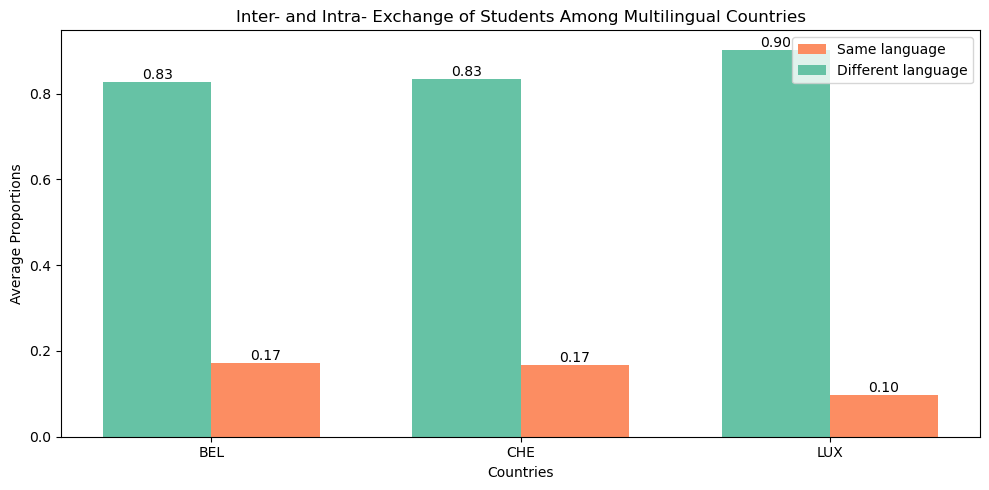

In [104]:
data = []
for i in range(10):
    year_data = {
        'BEL': belgium_proportions[i],
        'CHE': swiss_proportions[i],
        'LUX': lux_proportions[i]
    }
    data.append(year_data)

average_proportions_same, average_proportions_different = calculate_average_proportions(data)

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 5))

countries = list(average_proportions_same.keys())
intra_avg = [average_proportions_same[country] for country in countries]
inter_avg = [average_proportions_different[country] for country in countries]

bar_width = 0.35
index = range(len(countries))

palette = sns.color_palette("Set2")

bar2 = plt.bar([i + bar_width for i in index], inter_avg, bar_width, label='Same language', color=palette[1])
bar1 = plt.bar(index, intra_avg, bar_width, label='Different language', color=palette[0])

plt.xlabel('Countries')
plt.ylabel('Average Proportions')
plt.title('Inter- and Intra- Exchange of Students Among Multilingual Countries')
plt.xticks([i + bar_width / 2 for i in index], countries)
plt.legend()

for bar in bar1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')
    
for bar in bar2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

plt.savefig('multilingual_countries.pdf', format='pdf')
plt.tight_layout()
plt.show()

In [106]:
def generate_random_network(n, l, weight_range):
    G = nx.DiGraph()

    G.add_nodes_from(range(n))

    max_possible_edges = n * (n - 1)
    if l > max_possible_edges:
        raise ValueError(f"The number of edges {l} exceeds the maximum possible edges {max_possible_edges} for {n} nodes.")
    
    while G.number_of_edges() < l:
        node1 = random.randint(0, n-1)
        node2 = random.randint(0, n-1)

        if node1 != node2 and not G.has_edge(node1, node2):
            weight = random.uniform(weight_range[0], weight_range[1])
            G.add_edge(node1, node2, weight=weight)

    return G


random_networks = [[] for i in range(len(YEARS))]  # List of random networks for each year

for i, year in enumerate(YEARS):
    for j in range(20):  # Generate 20 random networks for each year
        random_networks[i].append(generate_random_network(len(students_graphs[i].nodes), len(students_graphs[i].edges), (0, 1))) # Normalized weights
        print(f'Generated random network {j+1} for year {year}')
    print('Finished generating random networks for year', year)


Generated random network 1 for year 2013
Generated random network 2 for year 2013
Generated random network 3 for year 2013
Generated random network 4 for year 2013
Generated random network 5 for year 2013
Generated random network 6 for year 2013
Generated random network 7 for year 2013
Generated random network 8 for year 2013
Generated random network 9 for year 2013
Generated random network 10 for year 2013
Generated random network 11 for year 2013
Generated random network 12 for year 2013
Generated random network 13 for year 2013
Generated random network 14 for year 2013
Generated random network 15 for year 2013
Generated random network 16 for year 2013
Generated random network 17 for year 2013
Generated random network 18 for year 2013
Generated random network 19 for year 2013
Generated random network 20 for year 2013
Finished generating random networks for year 2013
Generated random network 1 for year 2014
Generated random network 2 for year 2014
Generated random network 3 for year 2

In [107]:
ranodm_nodes = [i for i in range(37)]

cohort_sizes = [len(value) for value in language_to_country.values() if len(value) > 1]

for key, value in family_country_map.items():
    if len(value) > 1:
        cohort_sizes.append(len(value))

cohort_sizes = list(set(cohort_sizes))
print(cohort_sizes)

[2, 3, 4, 6, 7, 8, 11]


In [108]:
cohorts = [[] for _ in range(len(cohort_sizes))]

for i, size in enumerate(cohort_sizes):
    for j in range(size):
        
        while(True):
            node = random.choice(ranodm_nodes)
            if node not in cohorts[i]:
                cohorts[i].append(node)
                break

print(cohorts)

[[33, 36], [7, 22, 19], [3, 19, 1, 25], [0, 26, 23, 16, 15, 19], [6, 16, 4, 36, 10, 29, 27], [14, 25, 33, 31, 30, 9, 34, 28], [32, 31, 28, 20, 2, 21, 29, 24, 0, 35, 7]]


In [109]:
random_network_edges = [[[] for _ in range(20)] for i in range(len(YEARS))]

for i, year in enumerate(YEARS):
    for j in range(20):
        network = random_networks[i][j]
        for edge in list(random_networks[i][j].edges(data=True)):
            new_edge = {'origin': edge[0], 'destination': edge[1], 'value': edge[2]['weight']}
            random_network_edges[i][j].append(new_edge)

def modified_separate_edges(edges, countries):
    edges_intra =  [[] for i in range(20)]
    edges_inter = [[] for i in range(20)]

    for i in range(20):
        for edge in edges[i]:
            if edge['origin'] in countries and edge['destination'] in countries:
                edges_intra[i].append(edge)
            elif (edge['origin'] not in countries) and (edge['destination'] in countries):
                edges_inter[i].append(edge)

    return edges_intra, edges_inter

inter_intra_per_cohort = [[[] for _ in YEARS] for _ in cohorts]

In [110]:
for i, cohort in enumerate(cohorts):
    for j, year in enumerate(YEARS):
        inter_intra_per_cohort[i][j] = modified_separate_edges(random_network_edges[j], cohort)

In [111]:
def modified_get_proportions(intra, inter, cohort):
    proportions = {country : (0, 0) for country in cohort} # Country is destination
    
    for edge in intra:
        for e in edge:
            value = e['value']
            proportions[e['destination']] =  (proportions[e['destination']][0] + value, proportions[e['destination']][1])
        
    for edge in inter:
        for e in edge:
            value = e['value']
            proportions[e['destination']] = (proportions[e['destination']][0] , proportions[e['destination']][1] + value)
        
    return proportions

proportions_per_cohort = [[[] for _ in YEARS] for _ in cohorts]

for i, cohort in enumerate(cohorts):
    for j, year in enumerate(YEARS):
        proportions_per_cohort[i][j].append(modified_get_proportions(inter_intra_per_cohort[i][j][0], inter_intra_per_cohort[i][j][1], cohort))

In [112]:
def average_proportions(data):
    values = [0 for cohort in data]
    for index, cohort in enumerate(data):
        current_values = {'intra': 0, 'inter': 0}
        for year in cohort:
            current_dict = year[0]
            for key, value in current_dict.items():
                intra, inter = value
                intra = intra / 20 # average
                inter = inter / 20 # average
                
                current_values['intra'] += intra
                current_values['inter'] += inter
        
        current_values['intra'] = current_values['intra'] / len(YEARS)
        current_values['inter'] = current_values['inter'] / len(YEARS)
        
        values[index] = (current_values['intra'], current_values['inter'])
                
    return values

average_proportions_per_cohort = average_proportions(proportions_per_cohort)

In [113]:
cohort_proportion = {}
for cohort in cohorts:
    cohort_proportion[len(cohort)] = average_proportions_per_cohort[cohorts.index(cohort)]
print(cohort_proportion)

{2: (0.795624838232524, 29.608516390545486), 3: (2.4914550259475687, 42.638444328259304), 4: (5.017362162673611, 56.25766484487758), 6: (12.440691837212203, 78.83391496147102), 7: (17.17729594929271, 88.63592348667807), 8: (23.02446913547582, 99.09352576896535), 11: (45.14827153855284, 122.22580738471848)}


In [114]:
intra_proportion = {}
inter_proportion = {}

# Calculate proportions
for size, (intra, inter) in cohort_proportion.items():
    total = intra + inter
    intra_proportion[size] = intra / total
    inter_proportion[size] = inter / total

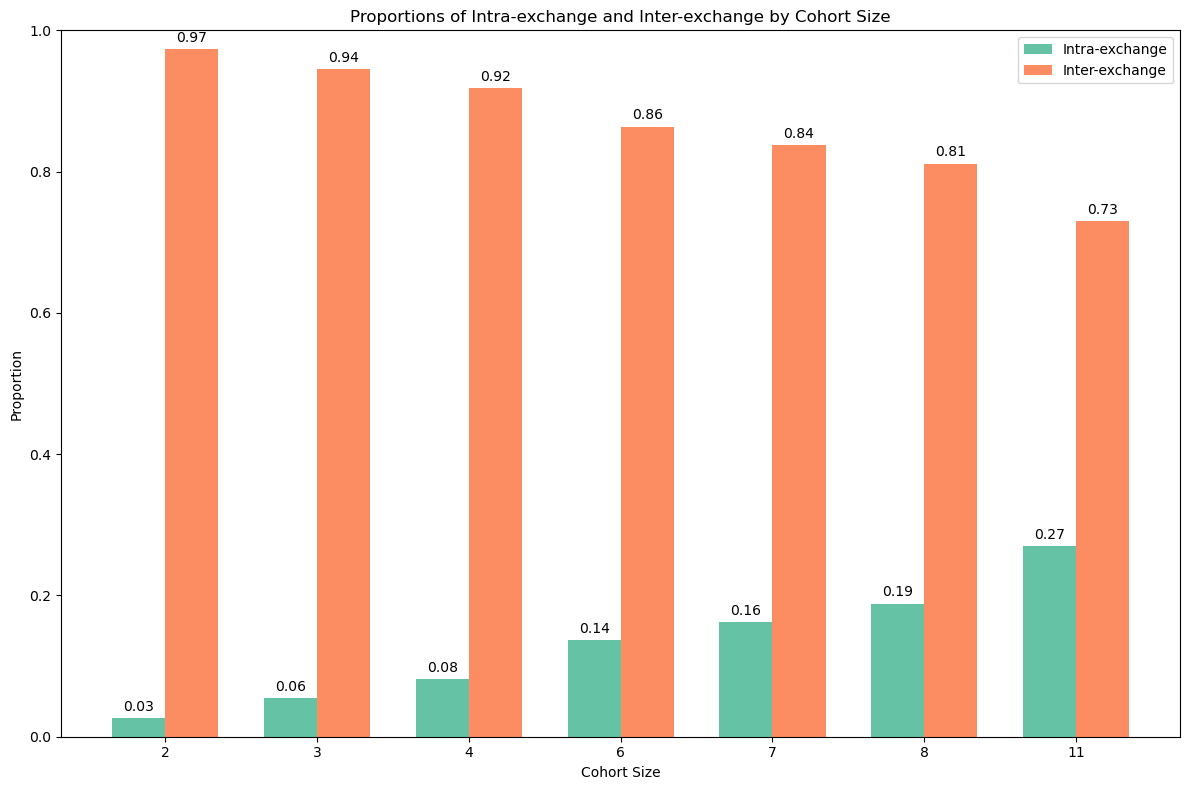

In [115]:
cohort_sizes = list(cohort_proportion.keys())
intra_values = [intra_proportion[size] for size in cohort_sizes]
inter_values = [inter_proportion[size] for size in cohort_sizes]

# Create the bar plot
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.35
index = np.arange(len(cohort_sizes))

# Plot intra and inter proportions side by side
bars_intra = ax.bar(index, intra_values, bar_width, label='Intra-exchange', color=palette[0])
bars_inter = ax.bar(index + bar_width, inter_values, bar_width, label='Inter-exchange', color=palette[1])

# Add labels and title
ax.set_xlabel('Cohort Size')
ax.set_ylabel('Proportion')
ax.set_title('Proportions of Intra-exchange and Inter-exchange by Cohort Size')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(cohort_sizes)
ax.set_ylim(0, 1)
ax.legend()

# Add values on top of bars
for bar in bars_intra:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

for bar in bars_inter:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')
    
plt.savefig('random_cohort_proportions.pdf', format='pdf')

plt.tight_layout()
plt.show()

In [116]:
def calculate_average_edge_weights(num_years, num_networks, nodes, edges_total):
    random_networks = [[] for _ in range(num_years)]
    average_edge_weights = [{} for _ in range(num_years)]

    for i in range(num_years):
        for j in range(num_networks):
            G = generate_random_network(len(students_graphs[i].nodes), len(students_graphs[i].edges), (0, 1))
            random_networks[i].append(G)

        # Calculate average weights
        edge_weights_sum = {}
        for G in random_networks[i]:
            for (u, v, data) in G.edges(data=True):
                if (u, v) not in edge_weights_sum:
                    edge_weights_sum[(u, v)] = 0
                edge_weights_sum[(u, v)] += data['weight']

        for (u, v), total_weight in edge_weights_sum.items():
            average_edge_weights[i][(u, v)] = total_weight / num_networks

    return average_edge_weights

In [117]:
average_edge_weights = calculate_average_edge_weights(len(YEARS), 20, nodes, edges_total)

# Prepare data for plotting net change
def prepare_net_change_data(average_edge_weights, num_years):
    net_change_data = [{} for _ in range(num_years)]

    for i in range(num_years):
        inflow = {}
        outflow = {}

        for (u, v), weight in average_edge_weights[i].items():
            if u not in outflow:
                outflow[u] = 0
            if v not in inflow:
                inflow[v] = 0

            outflow[u] += weight
            inflow[v] += weight

        net_change = {node: inflow.get(node, 0) - outflow.get(node, 0) for node in nodes}
        net_change_data[i] = net_change

    return net_change_data

net_change_data = prepare_net_change_data(average_edge_weights, len(YEARS))


In [118]:
# Set up the subplots
num_years = len(YEARS)
fig = make_subplots(rows=num_years, cols=1, subplot_titles=[f'Year {year}' for year in YEARS])

# Generate plots for each year
for i, year in enumerate(YEARS):
    net_change = net_change_data[i]

    nodes = list(net_change.keys())
    net_change_values = list(net_change.values())

    # Create trace for net change
    fig.add_trace(
        go.Bar(x=nodes, y=net_change_values, name=f'Net Change {year}', marker_color='blue'),
        row=i+1, col=1
    )

# Update layout
fig.update_layout(
    height=400*num_years,
    title_text='Net Change (Inflow - Outflow) for Nodes in Random Networks'
)

fig.write_html('net_change_outgoing_weights.html')
fig.show()
